In [4]:
import madmom
import aubio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import mir_eval


In [5]:
# Nacteni skladby
uploaded_file_name = "C:/Users/Zekon/Downloads/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/04.-Oh! Darling.wav"
y, sr = librosa.load(uploaded_file_name)


In [6]:
# Výpočet spektrogramu
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

In [7]:
act = madmom.features.beats.RNNBeatProcessor()(uploaded_file_name)

proc_beats = madmom.features.beats.BeatTrackingProcessor(fps =100)
proc_tempo = madmom.features.tempo.TempoEstimationProcessor(fps=100)
beats_madmom = proc_beats(act)
tempo_madmom = proc_tempo(act)


c:\Users\Zekon\AppData\Local\Programs\Python\Python311\Lib\site-packages\madmom\features\tempo.py:724: UserWarning: Usage of `method` is deprecated as of version 0.17. Please pass a dedicated `TempoHistogramProcessor` instance as `histogram_processor`.Functionality will be removed in version 0.19.
  warnings.warn(


In [8]:
tempo_librosa, beats_librosa = librosa.beat.beat_track(y=y, sr=sr)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)

In [9]:
def get_beats(filename):
    win_s = 512                 # velikost okna (vzorky)
    hop_s = win_s // 2          # velikost skoku (vzorky)
    samplerate = 0              

    s = aubio.source(filename, samplerate, hop_s)
    samplerate = s.samplerate

    tempo = aubio.tempo("default", win_s, hop_s, samplerate)

    beats = []
    while True:
        samples, read = s()
        is_beat = tempo(samples)
        if is_beat:
            this_beat = tempo.get_last_s()
            beats.append(this_beat)
        if read < hop_s: break

    return beats

audio_file = uploaded_file_name
beats_aubio = get_beats(audio_file)
beats_aubio = np.array(beats_aubio)
tempo_aubio = len(beats_aubio) / (beats_aubio[-1] - beats_aubio[0]) * 60

In [10]:

beats_reference = np.loadtxt("C:/Users/Zekon/Downloads/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/04_-_Oh!_Darling.txt")
beats_reference = beats_reference[:,0]

(25.0, 35.0)

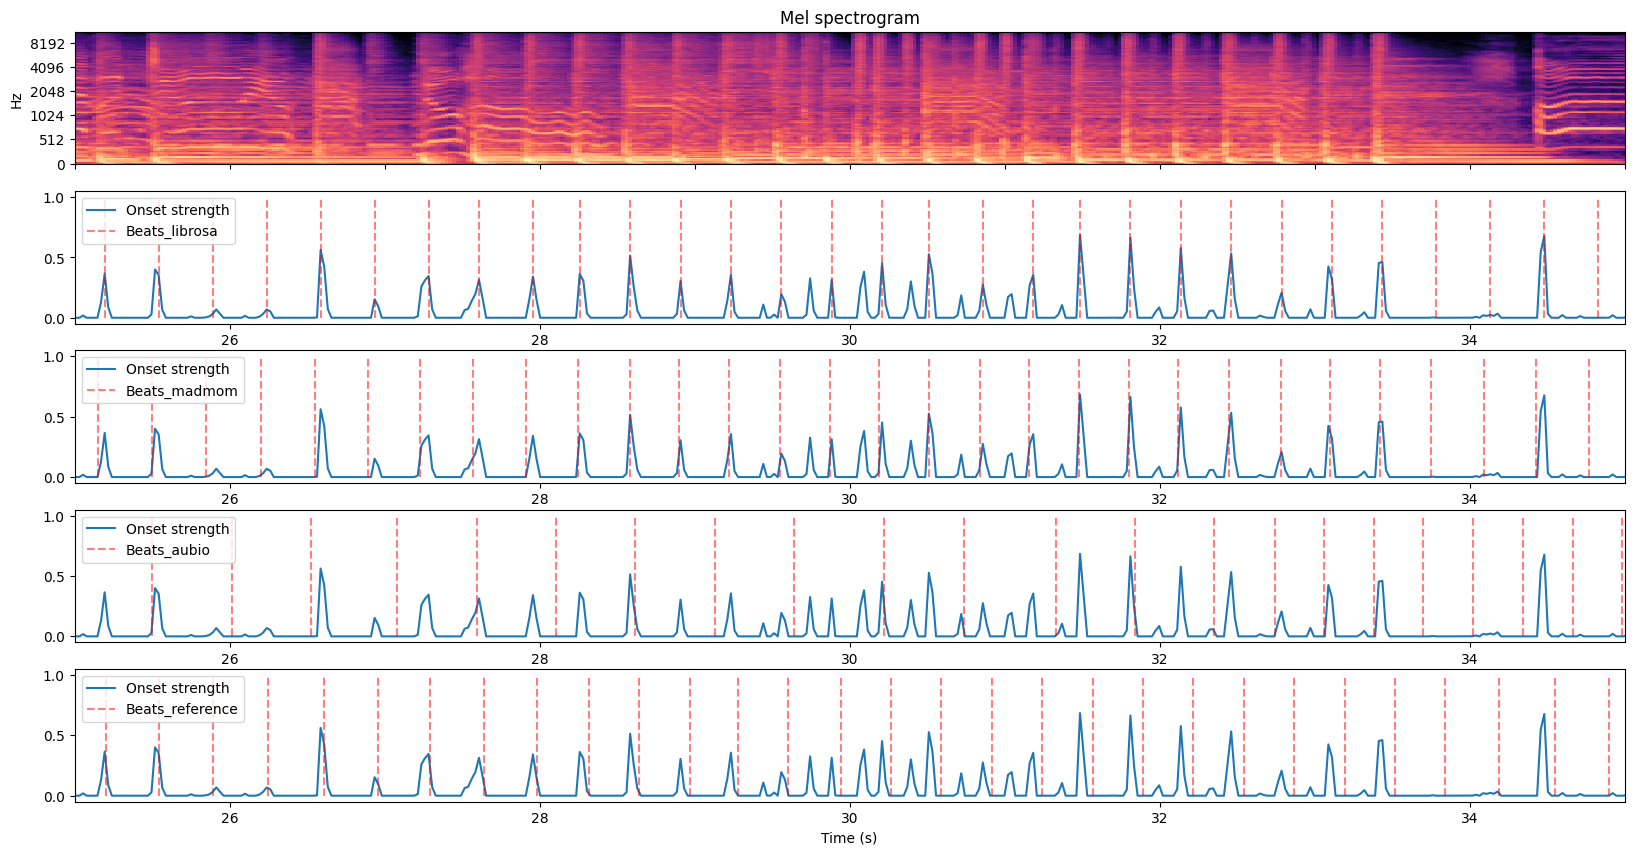

In [11]:
hop_length = 512
xmin_time = 25 # Čas skladby, oa kterého se vykreslí grafy.
xmax_time = 35 # Čas skladby, do kterého se vykreslí grafy.
fig, ax = plt.subplots(5,1, figsize=(20,10))

times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
beats_librosa = times[beats_librosa]
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[0].set_xlim(xmin=xmin_time, xmax=xmax_time)

ax[1].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].vlines(beats_librosa, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats_librosa')
ax[1].legend()
ax[1].set_xlabel("Time (s)")
ax[1].set_xlim(xmin=xmin_time, xmax=xmax_time)

ax[2].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[2].vlines(beats_madmom, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats_madmom')
ax[2].legend()
ax[2].set_xlabel("Time (s)")
ax[2].set_xlim(xmin=xmin_time, xmax=xmax_time)

ax[3].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[3].vlines(beats_aubio, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats_aubio')
ax[3].legend()
ax[3].set_xlabel("Time (s)")
ax[3].set_xlim(xmin=xmin_time, xmax=xmax_time)

ax[4].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[4].vlines(beats_reference, 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats_reference')
ax[4].legend()
ax[4].set_xlabel("Time (s)")
ax[4].set_xlim(xmin=xmin_time, xmax=xmax_time)

In [12]:
print(tempo_librosa)
print(tempo_madmom[0][0])
print(tempo_aubio)

172.265625
176.47058823529412
160.38274864382782


In [13]:
r_beats = mir_eval.beat.trim_beats(beats_reference)
l_beats = mir_eval.beat.trim_beats(beats_librosa)
m_beats = mir_eval.beat.trim_beats(beats_madmom)
a_beats = mir_eval.beat.trim_beats(beats_aubio)

score_librosa, _ = mir_eval.beat.cemgil(r_beats, l_beats)
score_madmom, _ = mir_eval.beat.cemgil(r_beats, m_beats)
score_aubio, _ =mir_eval.beat.cemgil(r_beats, a_beats)

print("Skóré Libros: ",f"{score_librosa: .4f}")
print("Skóré Madmom: ",f"{score_madmom: .4f}")
print("Skóré Aubio: ",f"{score_aubio: .4f}")

Skóré Libros:   0.3033
Skóré Madmom:   0.2782
Skóré Aubio:   0.2554
Skóré Maximální:   1.0000
